<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/Universe_Selection_Getting_Serious_about_Crypto_Stat_Arb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universe Selection and Getting Serious

Let's get serious about statistical arbitrage on cryptocurrency futures - rather than niche tail, squeeze effects.

To keep things simple, we will restrict ourselves to FTX perp futures products.

Which ones do we want?

For now, let's not restrict ourselves enormously - but we want to remove crap.

So let's:
 - exclude anything with price < 0.01 (arbitrary)
 - exclude the 20% remaining with lowest trailing monthly volume.

(means that perp needs to have existed for a month for us to look at it)

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'roll', 'tibbletime'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpbp1cLt/remotes7bdbe4e56/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



# What data do we want?

* Perp prices
* Perp funding rates

In [2]:
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw crypto load ftx futures v0.1
futures <- rwRtools::crypto_get_futures()

futures %>% 
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

# snippet: rw crypto load ftx perpetual funding rates v0.1
perp_rate <- rwRtools::crypto_get_perp_rates()

perp_rate %>%
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 232.4…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-07-20 12:00:00,2022-11-12


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-03-06 15:00:00,2022-11-12


# Join price and yields data

In [4]:
perp_rate %>% head()

ticker,date,rate
<chr>,<dttm>,<dbl>
1INCH-PERP,2020-12-25 03:00:00,0.000000
1INCH-PERP,2020-12-25 04:00:00,0.000000
1INCH-PERP,2020-12-25 05:00:00,0.000000
1INCH-PERP,2020-12-25 06:00:00,0.000558
1INCH-PERP,2020-12-25 07:00:00,0.000120
1INCH-PERP,2020-12-25 08:00:00,0.000123


In [5]:
universe <- futures %>% 
  inner_join(perp_rate, by = c('ticker','date')) 

universe %>% head()

ticker,date,open,high,low,close,volume,rate
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1INCH-PERP,2020-12-25 05:00:00,2.38335,3.1132,2.2866,2.5700,2970965,0.000000
1INCH-PERP,2020-12-25 06:00:00,2.57000,2.6621,2.2278,2.5112,2220601,0.000558
1INCH-PERP,2020-12-25 07:00:00,2.51010,2.8200,2.3660,2.6334,2654891,0.000120
1INCH-PERP,2020-12-25 08:00:00,2.63340,2.8020,2.4711,2.6150,3450362,0.000123
1INCH-PERP,2020-12-25 09:00:00,2.61500,2.7300,2.5733,2.6403,1680502,0.000023
1INCH-PERP,2020-12-25 10:00:00,2.64030,2.9613,2.6270,2.7793,3842093,0.000078


## Calculate log returns

The "rate" is the funding rate, which is the rate that shorts would receive at the beginning of each hour.

To make the data easier to work, with let's assume that the funding event happens at the end of the previous hour. 

That lets us calculate returns from:
 * price change
 * funding accrual
 * total return.

Which we can work with easily

In [6]:
universe <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    m2m_returns_simple = close/lag(close, 1) - 1,
    m2m_returns_log = log(m2m_returns_simple + 1),
    funding_returns_simple = lead(-rate),
    funding_returns_log = log(funding_returns_simple + 1),
    total_returns_simple = m2m_returns_simple + funding_returns_simple,
    total_returns_log = log(total_returns_simple + 1)
  )

universe %>% head()


ticker,date,open,high,low,close,volume,rate,m2m_returns_simple,m2m_returns_log,funding_returns_simple,funding_returns_log,total_returns_simple,total_returns_log
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALGO-PERP,2019-07-20 12:00:00,0.7172,0.7172,0.7125,0.7161,0.000,8.0e-06,NA,NA,-0.000003,-3.000004e-06,NA,NA
ALT-PERP,2019-07-20 12:00:00,767.5000,769.5000,762.4000,764.8000,769094.765,2.0e-05,NA,NA,-0.000010,-1.000005e-05,NA,NA
BCH-PERP,2019-07-20 12:00:00,317.7000,322.0000,315.5000,316.2000,0.000,-4.6e-05,NA,NA,0.000108,1.079942e-04,NA,NA
BNB-PERP,2019-07-20 12:00:00,30.7225,30.7725,30.6250,30.6250,22151.658,4.2e-05,NA,NA,-0.000054,-5.400146e-05,NA,NA
BSV-PERP,2019-07-20 12:00:00,171.7200,173.4700,165.0300,167.1000,2177.171,8.0e-06,NA,NA,-0.000009,-9.000041e-06,NA,NA
BTC-PERP,2019-07-20 12:00:00,10564.2500,10630.0000,10525.5000,10539.5000,10529974.286,1.1e-05,NA,NA,0.000003,2.999995e-06,NA,NA


## Apply universe criteria

In [7]:
universe <- universe %>% 
  mutate(
    is_universe_price = min(open, high, low, close) >= 0.01,
    trail_volume = roll_mean(volume, 30 * 24)
  ) %>%
  na.omit() %>%
  group_by(date) %>%
  mutate(
    volume_decile = ntile(trail_volume, 10),
    is_universe_volume = volume_decile >= 3,
    is_universe = is_universe_price & is_universe_volume
  )

# Resample to daily to work on to start with

We don't want to messing about with lots of data or with fast hard-to-trade things, so let's restrict to daily data for now.

In [8]:
daily <- universe %>% 
  mutate(
    datetime = date,
    date = as_date(date)
  ) %>%
  group_by(date, ticker) %>%
  arrange(datetime) %>% 
  summarize(
    open = first(open),
    high = max(high),
    low = min(low),
    close = last(close),
    volume = sum(volume),
    m2m_returns_log = sum(m2m_returns_log),
    m2m_returns_simple = exp(m2m_returns_log) - 1,
    funding_returns_log = sum(funding_returns_log),
    funding_returns_simple = exp(funding_returns_log) - 1,
    total_returns_simple = m2m_returns_simple + funding_returns_simple,
    total_returns_log = log(total_returns_simple + 1),
    is_universe = sum(is_universe) > 0
  )

daily %>% head()

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `total_returns_log = log(total_returns_simple + 1)`.
ℹ In group 111905: `date = 2022-11-10`, `ticker = "ASD-PERP"`.
Caused by warning in `log()`:
! NaNs produced”
`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


date,ticker,open,high,low,close,volume,m2m_returns_log,m2m_returns_simple,funding_returns_log,funding_returns_simple,total_returns_simple,total_returns_log,is_universe
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
2019-08-19,ALGO-PERP,0.6679,0.6763,0.6561,0.6563,108518.64,-0.017520460,-0.017367869,-0.0006680209,-0.0006677978,-0.018035667,-0.018200292,TRUE
2019-08-19,ALT-PERP,666.9000,670.5000,653.6000,667.6000,200431.11,0.001049082,0.001049633,0.0003039953,0.0003040415,0.001353674,0.001352759,TRUE
2019-08-19,BCH-PERP,323.7500,326.4000,318.2500,325.3500,83038.66,0.004929913,0.004942085,-0.0002970046,-0.0002969605,0.004645124,0.004634369,FALSE
2019-08-19,BNB-PERP,28.8850,29.0225,28.4250,28.8225,556707.14,-0.002166097,-0.002163753,0.0006769289,0.0006771581,-0.001486595,-0.001487701,TRUE
2019-08-19,BSV-PERP,144.2800,145.9400,142.0500,145.6200,80436.74,0.009244633,0.009287497,-0.0002160033,-0.0002159800,0.009071517,0.009030618,TRUE
2019-08-19,BTC-PERP,10723.5000,10945.5000,10645.2500,10930.7500,41281621.08,0.019142323,0.019326712,-0.0002700043,-0.0002699678,0.019056745,0.018877439,TRUE


`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


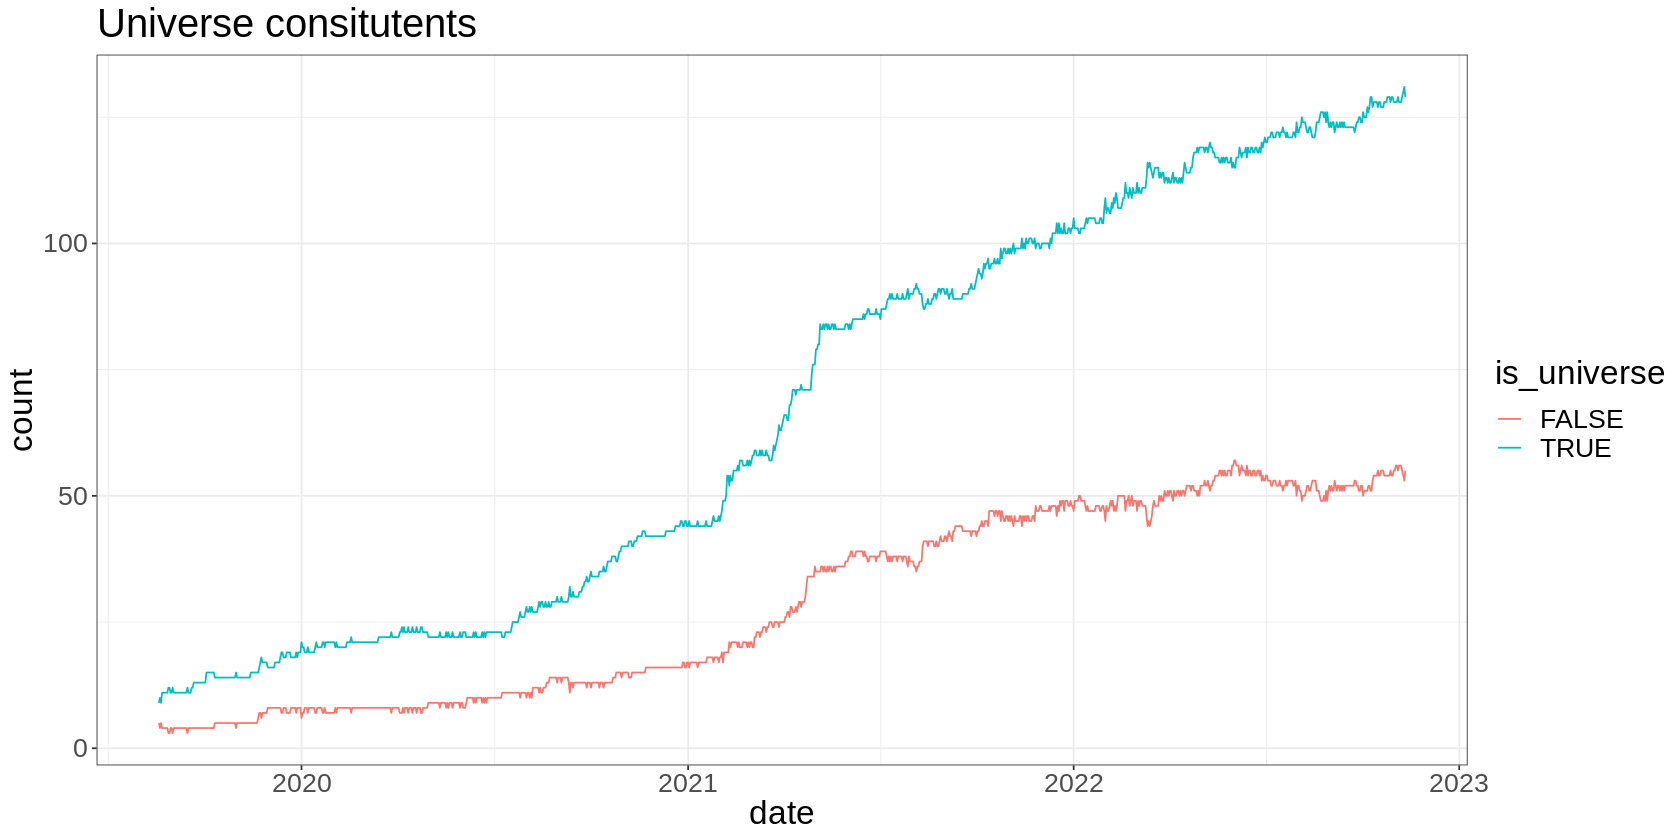

In [10]:
daily %>%
  group_by(date, is_universe) %>%
  summarize(count = n()) %>%
  ggplot(aes(x=date, y=count, color = is_universe)) + geom_line() + ggtitle('Universe consitutents')

# Look at simple breakout and carry features

Today, we'll look at two very simple features.

- Breakout = closeness to recent 20 day highs: 9.5 - new highs today / -9.5 = new highs 20 days ago
- Carry - mean funding over last 24 hours

## Calculate the raw features and lag them

First we calculate the raw features and lag them by one observation.

In [11]:
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 20, na_value = NA), 
  otherwise = NA
)

features <- daily %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    breakout = lag(9.5 - rolling_days_since_high_20(close)),
    carry = lag(funding_returns_log)
  ) %>%
  na.omit()

# Information Coefficient of Raw Features vs Raw Returns

Let's look at the information coefficients of the raw features

In [12]:
features %>%
  ungroup() %>%
  filter(is_universe) %>%
  summarize(
    breakout_IC = cor(breakout, total_returns_log),
    carry_IC = cor(carry, total_returns_log)
  )

breakout_IC,carry_IC
<dbl>,<dbl>
0.009291809,0.07450299


Each raw feature can explain about 2-3% of the variance in next day total returns.

Let's look at it by year

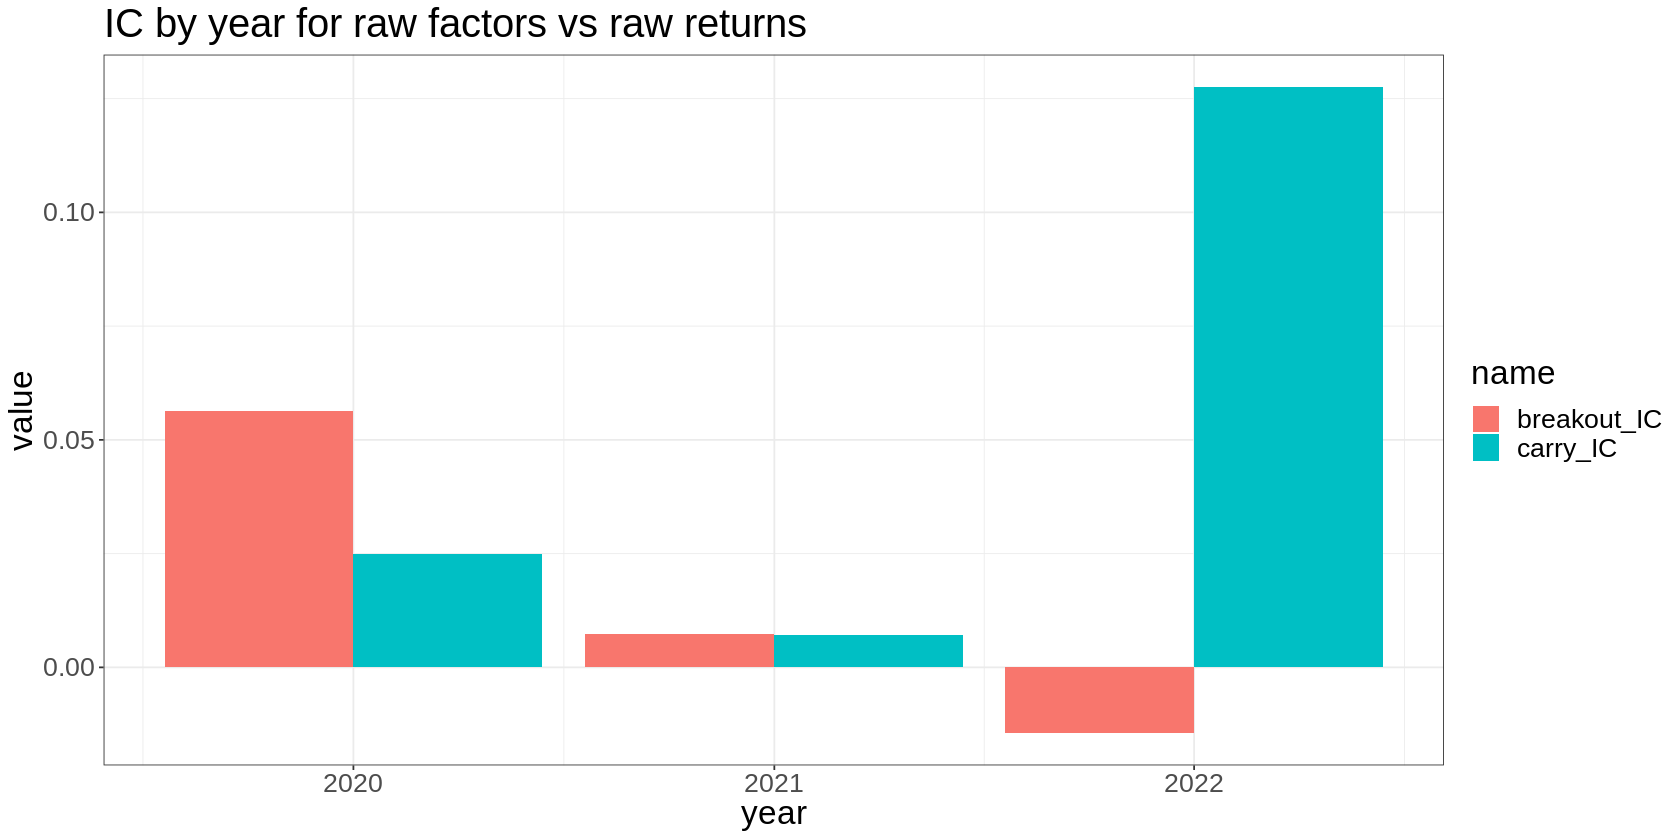

In [13]:
features %>%
  mutate(year = floor_date(date, 'year')) %>%
  filter(year > '2019-01-01') %>% #hardly any data
  group_by(year) %>%
  filter(is_universe) %>%
  summarize(
    breakout_IC = cor(breakout, total_returns_log),
    carry_IC = cor(carry, total_returns_log)
  ) %>% 
  pivot_longer(-year) %>%
  ggplot(aes(x=year, y=value, fill=name)) + geom_bar(stat='identity', position = 'dodge') + ggtitle('IC by year for raw factors vs raw returns')

## Scaling and Normalization

We can look at different normalization techniques... let's do these separately so we can plot them easy.

We look at:
 - de-meaning - taking the daily mean away from each observation
 - zscoring - the number of standard devations away from the daily mean each asset is
 - decile - sort each assets into 10 equal buckets by the feature 
 - sorting by an assets history, then across assets.

## Breakouts

When you think about it, the breakout feature is nicely normalized between -9.5 and 9.5 so it probably doesn't need much done to it.

We could normalize it for each day... which would kinda be like forcing a trend feature to behave like a momentum feature. 


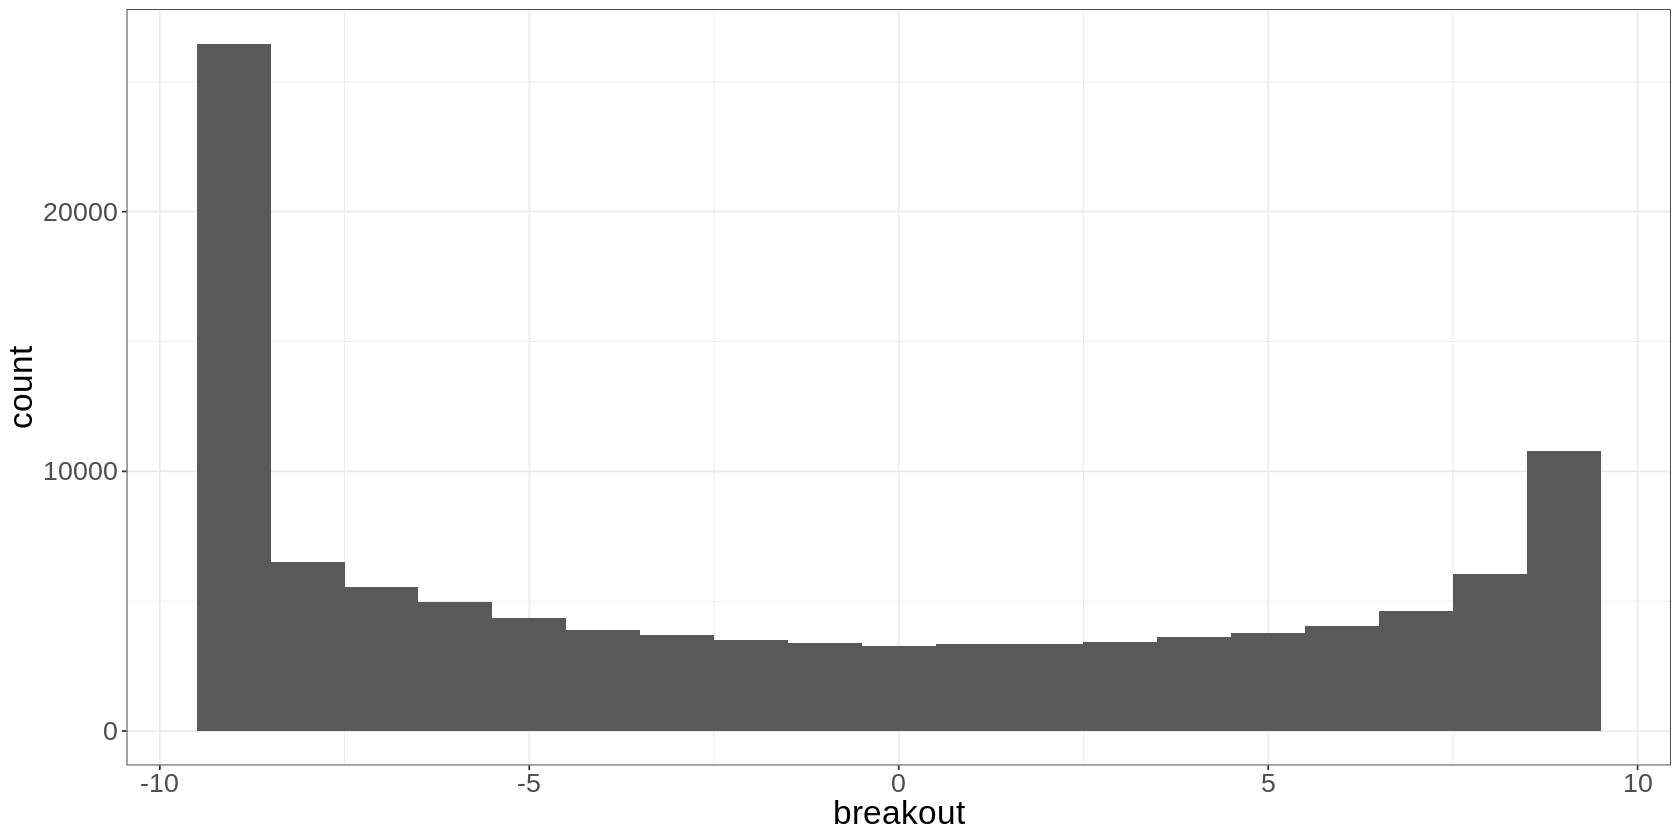

In [14]:
features %>%
  ggplot(aes(x=breakout)) + geom_histogram(bins=20)

Adding missing grouping variables: `date`


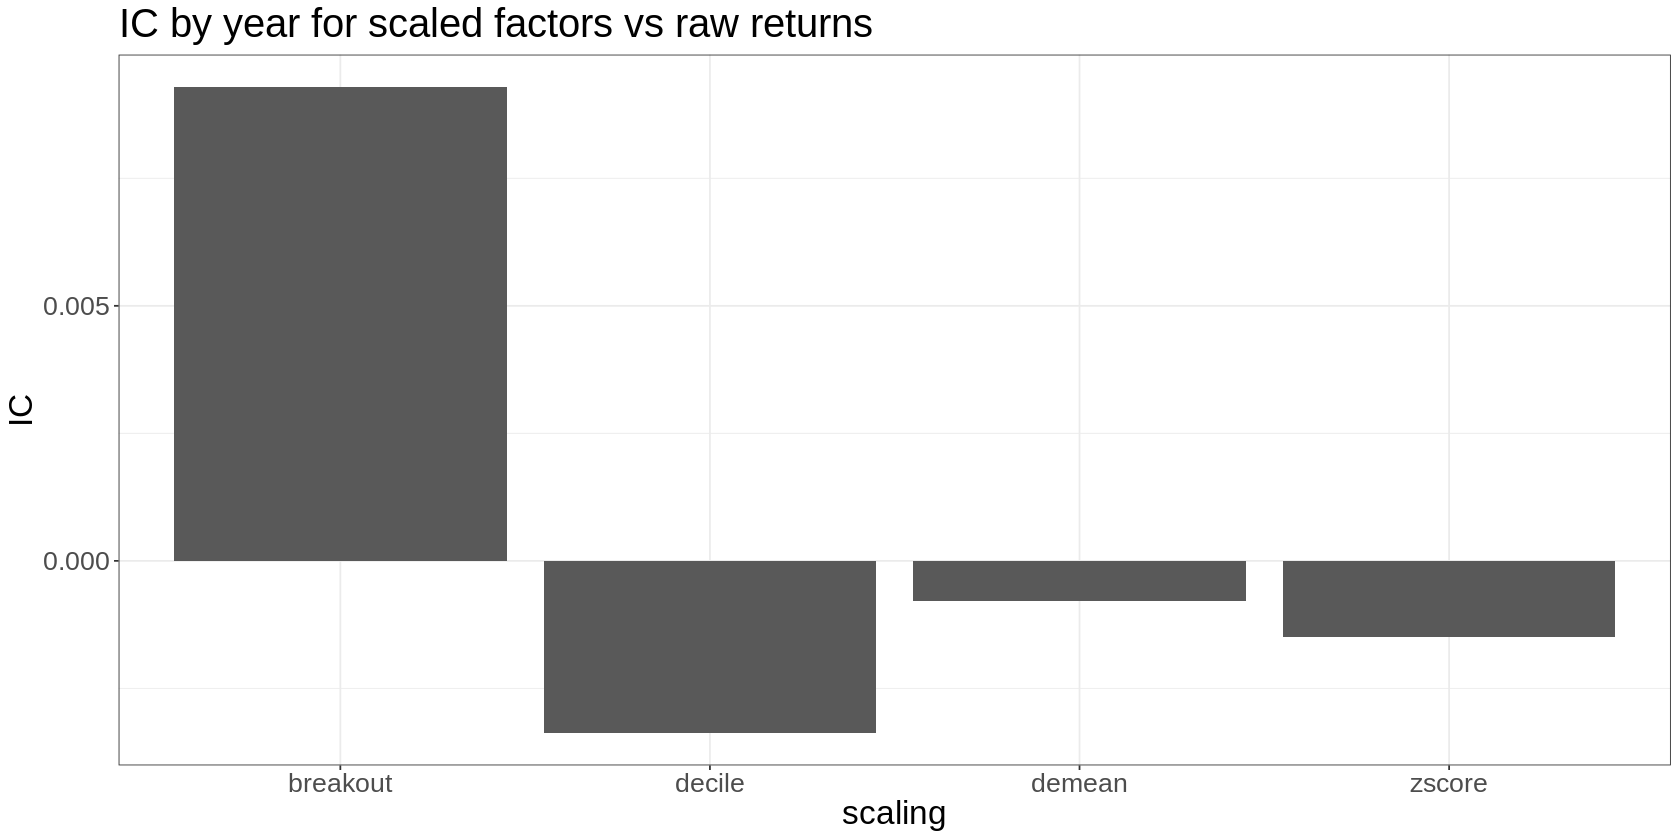

In [15]:
features %>% 
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    demean = breakout - mean(breakout),
    zscore = demean / sd(breakout),
    decile = ntile(breakout, 10)
  ) %>% 
  select(ticker, breakout, demean, zscore, decile, total_returns_log) %>%
  pivot_longer(c(breakout, demean, zscore, decile), names_to='scaling') %>%
  group_by(scaling) %>%
  summarize(IC = cor(value, total_returns_log)) %>%
  ggplot(aes(x=scaling, y=IC)) + geom_bar(stat='identity') + ggtitle('IC by year for scaled factors vs raw returns')


As expected, not scaling tends to do better. We already kinda normalized it, right? And it's a trend-following thing.

Now let's do the same for de-meaned retturns, looking at how well the trend features predict relative retturns between assets.

Adding missing grouping variables: `date`


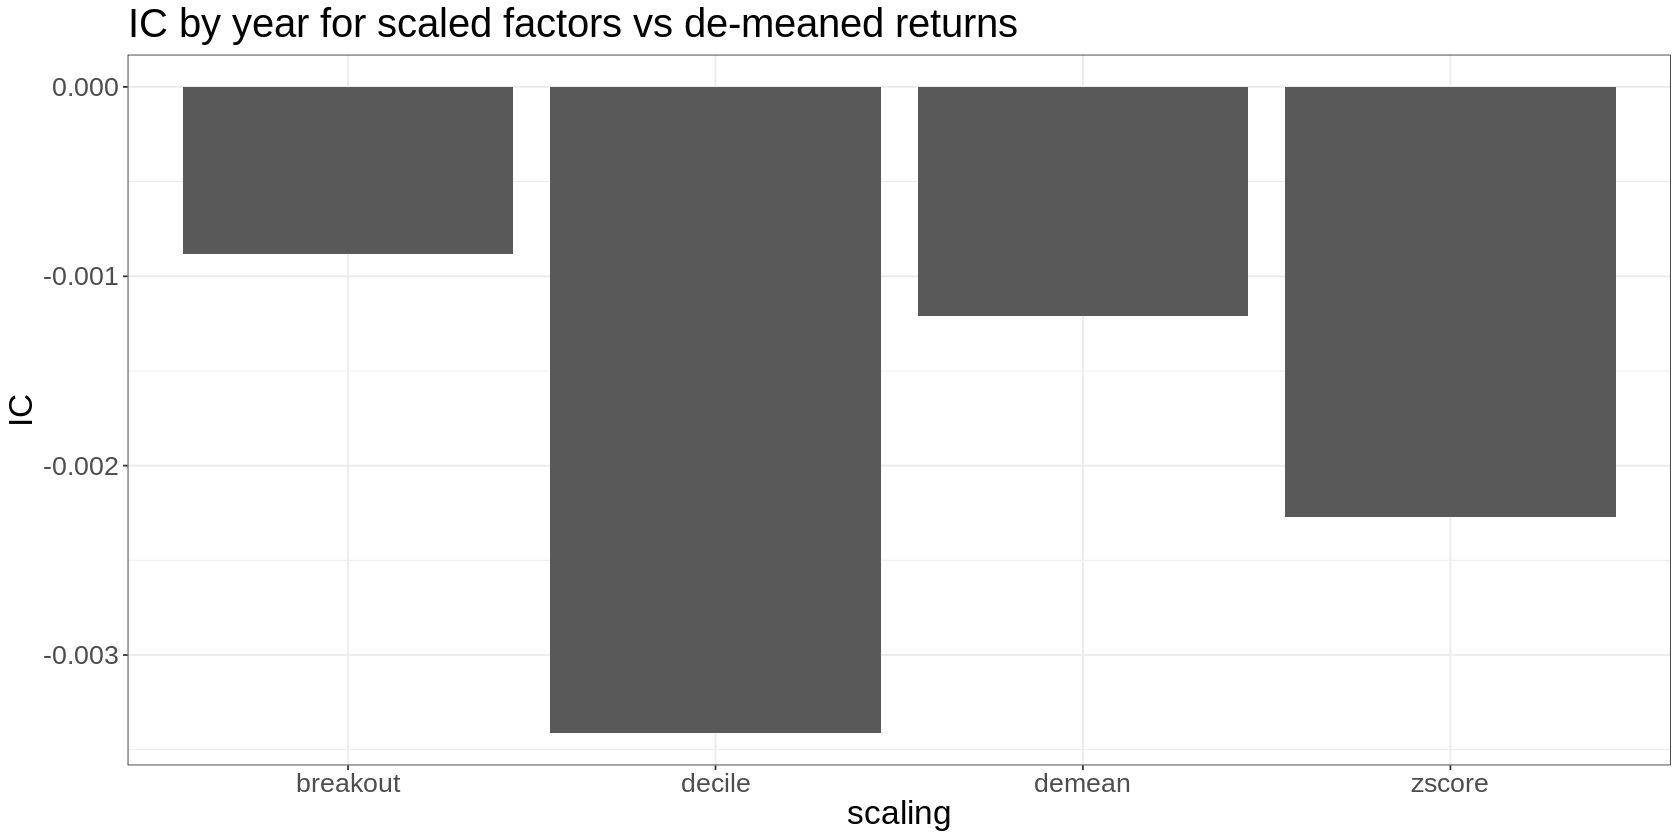

In [16]:
features %>% 
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    demean = breakout - mean(breakout),
    zscore = demean / sd(breakout),
    decile = ntile(breakout, 10),
    demeaned_returns = total_returns_log - mean(total_returns_log)
  ) %>% 
  select(ticker, breakout, demean, zscore, decile, demeaned_returns) %>%
  pivot_longer(c(breakout, demean, zscore, decile), names_to='scaling') %>%
  group_by(scaling) %>%
  summarize(IC = cor(value, demeaned_returns)) %>%
  ggplot(aes(x=scaling, y=IC)) + geom_bar(stat='identity') + ggtitle('IC by year for scaled factors vs de-meaned returns')

We find it's not effective at predicting relative returns... Maybe not a surprise as trend effects generally play out at the market level.


## Carry 

Now let's look do the same fot the carry factor.

First we look at raw returns.

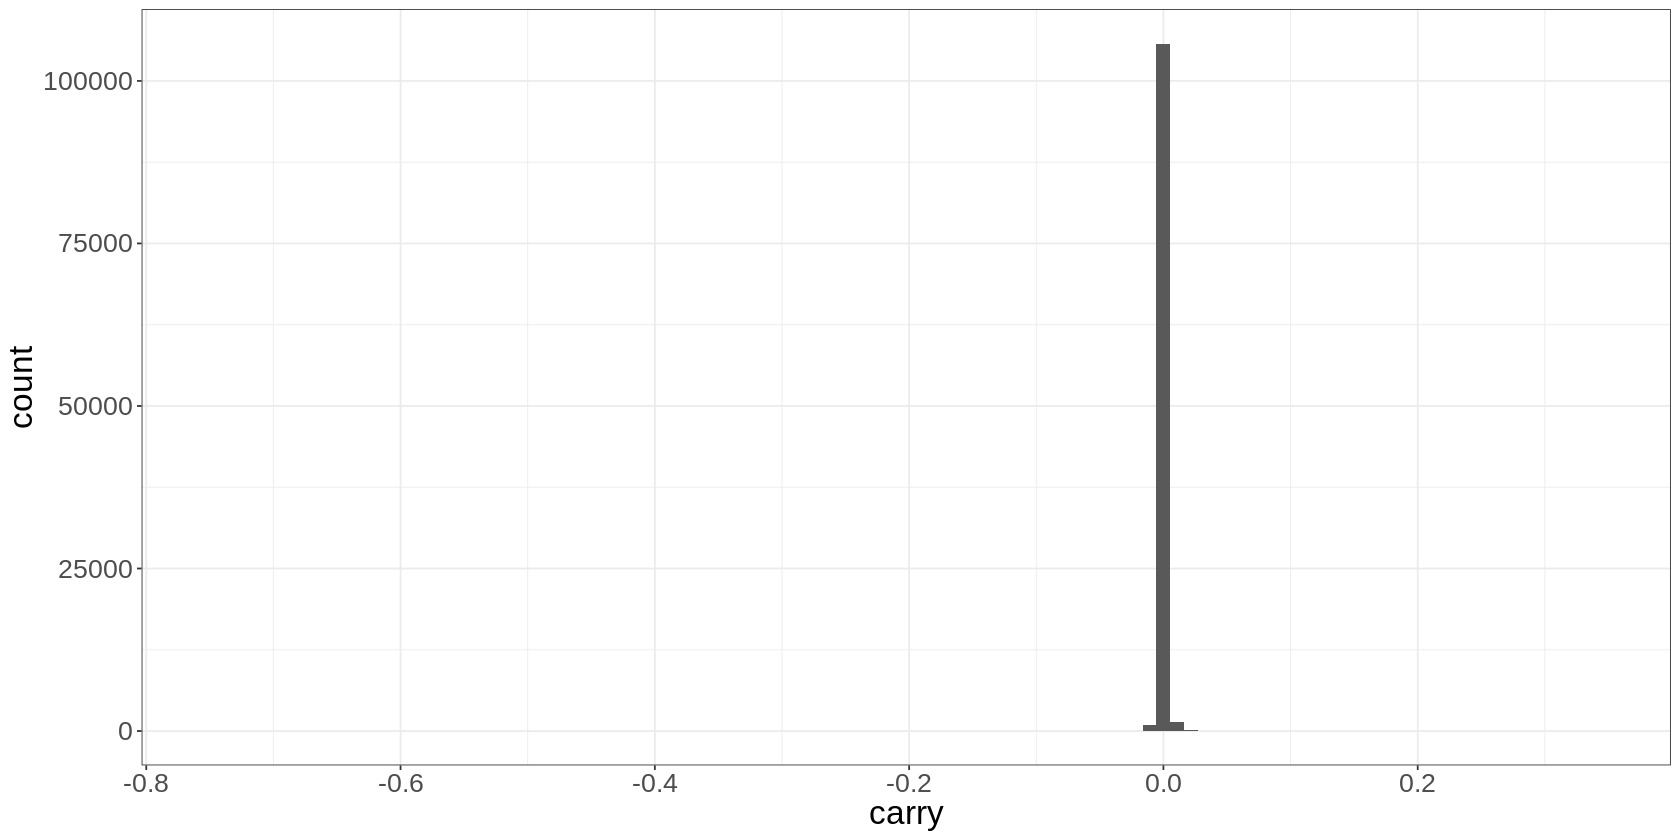

In [17]:
features %>%
  ggplot(aes(x=carry)) + geom_histogram(bins=100)

Adding missing grouping variables: `date`


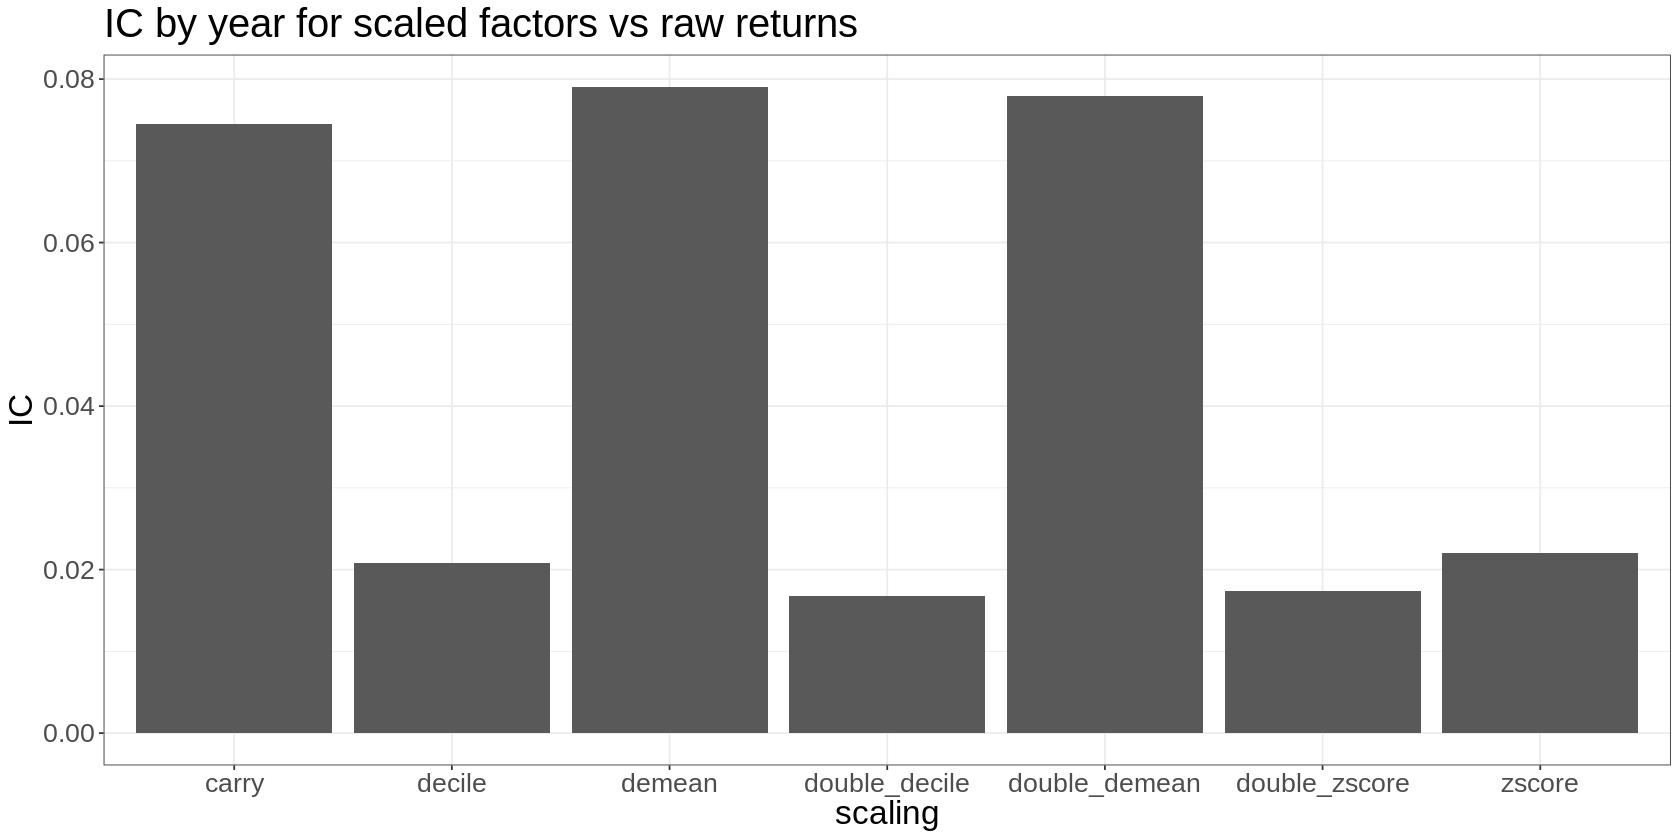

In [18]:
features %>% 
  filter(is_universe) %>%
  group_by(ticker) %>% 
  mutate(
    ticker_demean = carry - mean(carry),
    ticker_zscore = ticker_demean / sd(carry),
    ticker_decile = ntile(carry, 10)) %>%
  group_by(date) %>%
  mutate(
    demean = carry - mean(carry),
    zscore = demean / sd(carry),
    decile = ntile(carry, 10),
    double_demean = ticker_demean - mean(ticker_demean),
    double_zscore = (ticker_zscore - mean(ticker_zscore)) / sd(ticker_zscore),
    double_decile = ntile(ticker_decile, 10),
    demeaned_returns = total_returns_log - mean(total_returns_log)
  ) %>% 
  select(ticker, carry, demean, zscore, decile, double_demean, double_zscore, double_decile, total_returns_log, demeaned_returns) %>%
  pivot_longer(c(carry, demean, zscore, decile, double_demean, double_zscore, double_decile), names_to='scaling') %>%
  group_by(scaling) %>%
  summarize(IC = cor(value, total_returns_log)) %>%
  ggplot(aes(x=scaling, y=IC)) + geom_bar(stat='identity') + ggtitle('IC by year for scaled factors vs raw returns')

The more we truncate it, the lower the IC, consistent with what we saw at the extremes.

Now let's look at de-meaned returns, which more closely matches how we might imagine trading a long/short carry signal.


Adding missing grouping variables: `date`


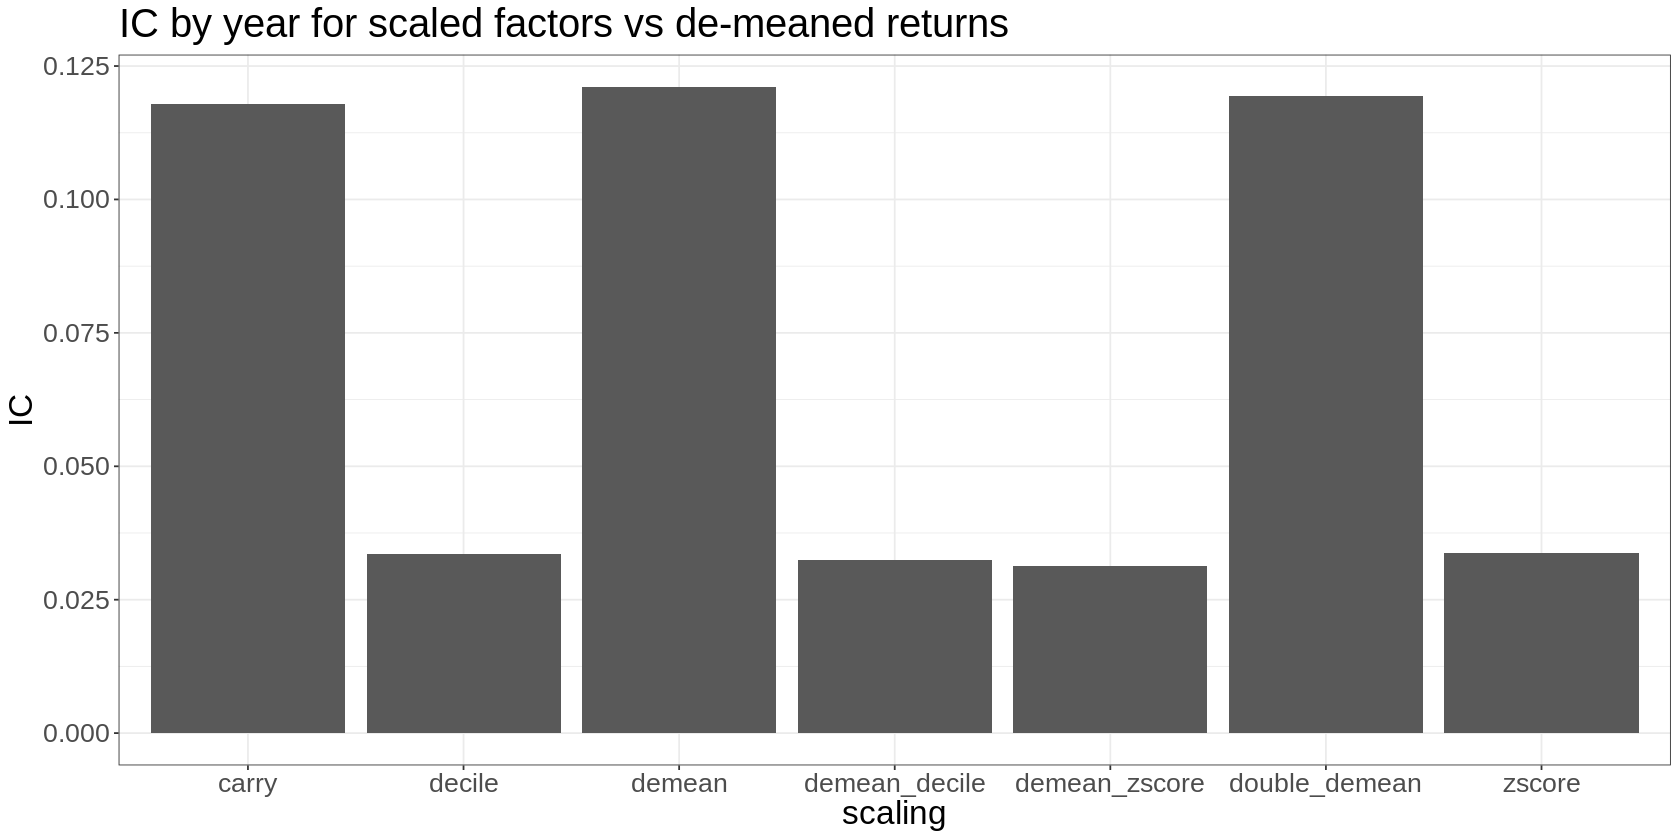

In [19]:
features %>% 
  filter(is_universe) %>%
  group_by(ticker) %>% 
  # This is a dirty sort
  mutate(
    ticker_demean = carry - mean(carry),
    ticker_zscore = ticker_demean / sd(carry),
    ticker_decile = ntile(carry, 10)) %>%
  group_by(date) %>%
  mutate(
    demean = carry - mean(carry),
    zscore = demean / sd(carry),
    decile = ntile(carry, 10),
    double_demean = ticker_demean - mean(ticker_demean),
    demean_zscore = (ticker_demean - mean(ticker_demean)) / sd(ticker_demean),
    demean_decile = ntile(ticker_demean, 10),
    demeaned_returns = total_returns_log - mean(total_returns_log)
  ) %>% 
  select(ticker, carry, demean, zscore, decile, double_demean, demean_zscore, demean_decile, total_returns_log, demeaned_returns) %>%
  pivot_longer(c(carry, demean, zscore, decile, double_demean, demean_zscore, demean_decile), names_to='scaling') %>%
  group_by(scaling) %>%
  summarize(IC = cor(value, demeaned_returns)) %>%
  ggplot(aes(x=scaling, y=IC)) + geom_bar(stat='identity') + ggtitle('IC by year for scaled factors vs de-meaned returns')

# A Toy Strategy Approach

How do we convert alphas into a trading strategy?

Let's take a very simple approach where we look to:
 - Scale our alphas
 - Hold each asset in proportion to the alpha.

Effectively here, we're assuming each asset as equally risky and there's no benefit from combining them

Just to show you how we might put together things... 

We'll do a very hacky simulation where we weight each perp:
 - in proportion to the zscore of the carry 
 - in proportion to the breakout rank (scaled to 1/5 to be of similar magnitude)


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


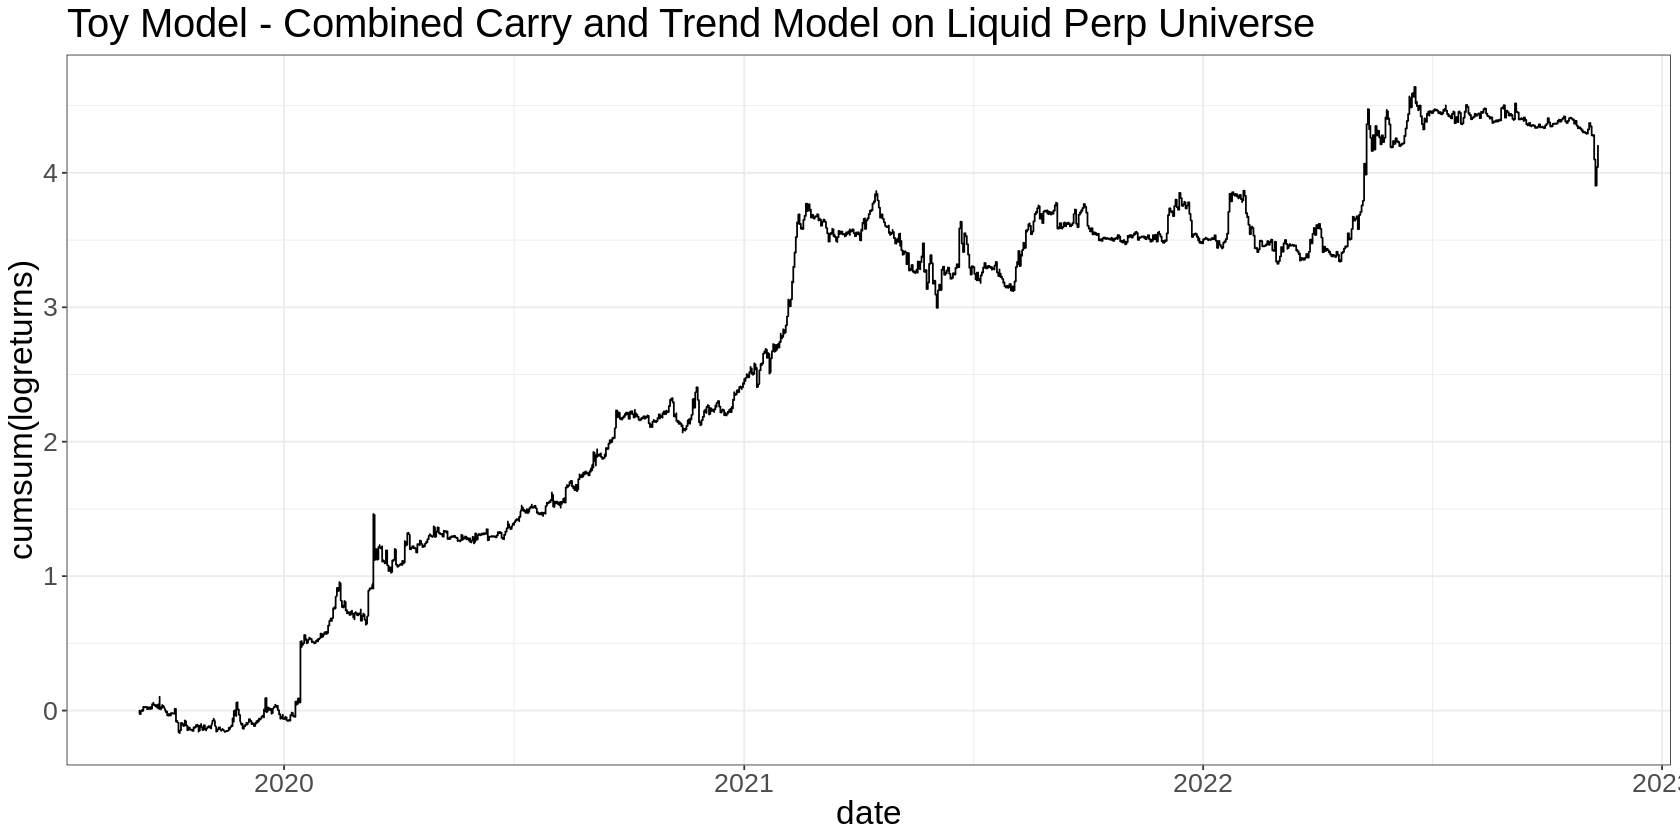

In [20]:
features %>%
  filter(is_universe) %>%
  group_by(ticker) %>% 
  # This is a dirty sort
  mutate(ticker_demean = carry - mean(carry)) %>%
  group_by(date) %>%
  mutate(
    carry_weight = (ticker_demean - mean(ticker_demean)) / sd(ticker_demean),
    breakout_weight = breakout / 5 , # Frigged cos breakout runs between -9 and 9
    total_weight = (carry_weight + breakout_weight) / n()
  ) %>%
  summarize(returns = total_weight * total_returns_simple) %>%
  mutate(logreturns = log(returns+1)) %>%
  ggplot(aes(x=date, y=cumsum(logreturns))) + geom_line() + ggtitle('Toy Model - Combined Carry and Trend Model on Liquid Perp Universe')

That's a totally unrealistic simulation but it still looks better than i expected it to, to be honest.

# What next?

Model features carefully
- Carry (w/ drift modifications?)
- Trend / volume